### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
def process_datetimes(df:pd.DataFrame) -> pd.DataFrame:
    datetimes = df['datetime']
    datetime_df = pd.DataFrame(columns=['year', 'month', 'day', 'hour', 'minute', 'second'])
    for n,i in enumerate(datetimes):
        date,time = i.split()
        date = date.split('-')
        year = int(date[0])
        month = int(date[1])
        day = int(date[2])
        time = time.split(':')
        hour = int(time[0])
        minute = int(time[1])
        second = int(time[2])
        new_row = pd.DataFrame({"year":year, "month":month, "day": day, "hour":hour, "minute":minute, "second":second}, index=[n])
        datetime_df = pd.concat([datetime_df, new_row])
    return datetime_df

In [3]:
'''
Training data has "casual" and "registered" columns
the data is always for the first 19 days of the month
Testing data doesn't have those columns and is for the 20th until the end of the month
When training with the casual and registered columns, the model performs much better than without those columns
need to create the features for the testing data
what are some ways to do so?

sklearn has a simpleimputer class that can be used to fit the columns from the training set into the testing set
'''

'\nTraining data has "casual" and "registered" columns\nthe data is always for the first 19 days of the month\nTesting data doesn\'t have those columns and is for the 20th until the end of the month\nWhen training with the casual and registered columns, the model performs much better than without those columns\nneed to create the features for the testing data\nwhat are some ways to do so?\n\nsklearn has a simpleimputer class that can be used to fit the columns from the training set into the testing set\n'

### Read and Process Data

#### Process Training Data

In [4]:
data_train = pd.read_csv("train.csv")
datetime_df = process_datetimes(data_train)
processed = data_train.drop(columns=['datetime'], inplace=True)
processed = pd.concat([data_train.reset_index(drop=True), datetime_df.reset_index(drop=True)], axis=1)
processed = pd.get_dummies(processed, columns=['season', 'weather'], dtype=int)
scaler = MinMaxScaler()
columns_to_scale = processed.columns.tolist()
columns_list = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
for column in columns_to_scale:
    if column in columns_list:
        scaled_column = scaler.fit_transform(processed[[column]])
        processed[column] = scaled_column

### Training

In [5]:
# processed['temp'].plot.hist()
# plt.figure()
y = processed['count']
x = processed.drop(columns=['count', 'year', 'holiday'])
# x['temp'].plot.hist()
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

#### Decision Tree Regressor

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_log_error
dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)
predictions = dt.predict(x_test)

#### Model Evaluation

R^2: 0.9984173434712343 
Root Mean Squared Log Error: 0.02943466826990842


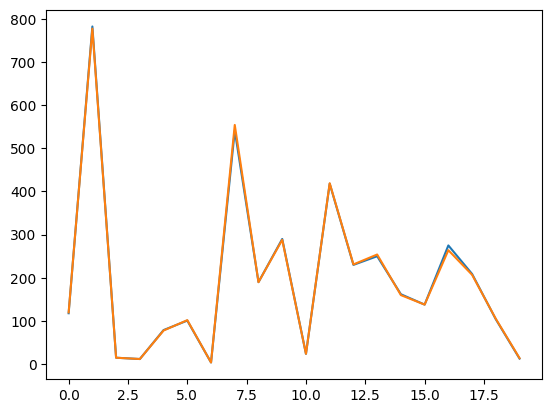

In [7]:
r2 = r2_score(y_true=y_test, y_pred=predictions)
rmsle = root_mean_squared_log_error(y_true=y_test, y_pred=predictions)
print(f"R^2: {r2} ")
print(f"Root Mean Squared Log Error: {rmsle}")
xs = [n for n in range(len(x_test))]
plt.figure()
plt.plot(xs[0:20], y_test.to_numpy()[0:20])
plt.plot(xs[0:20], predictions[0:20])
plt.show()

#### Process Testing Data

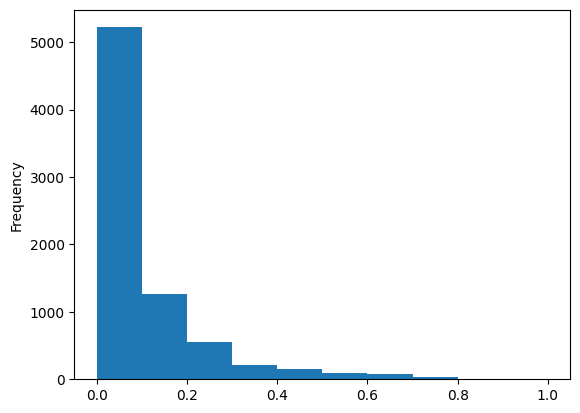

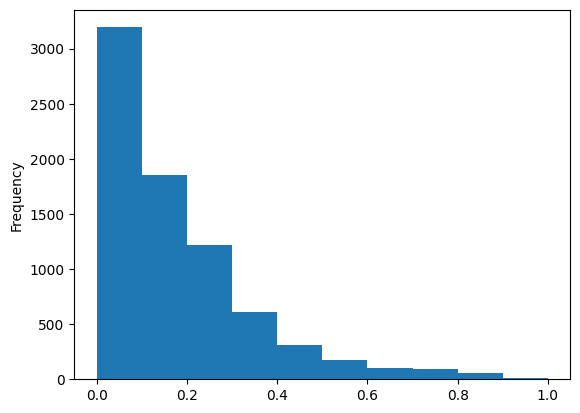

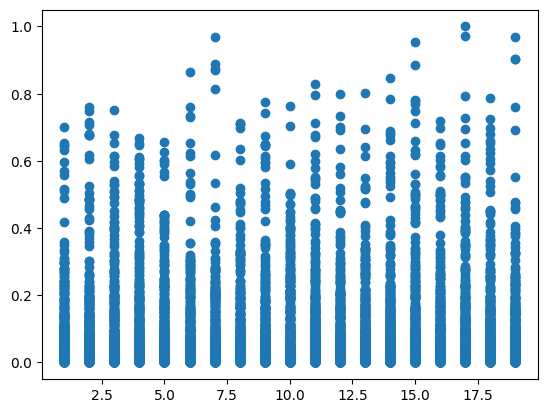

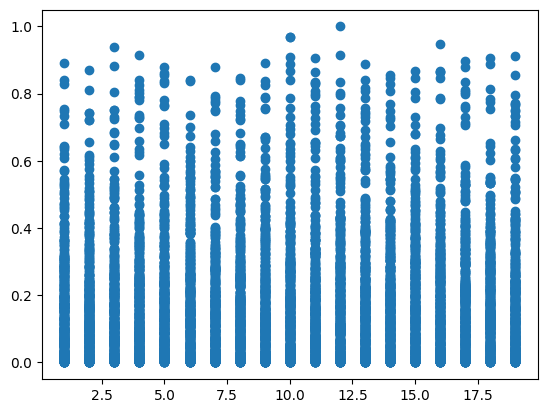

In [30]:
x_train['casual'].plot.hist()
plt.figure()
x_train['registered'].plot.hist()
plt.figure()
plt.scatter(x_train['day'], x_train['casual'])
plt.figure()
plt.scatter(x_train['day'], x_train['registered'])

In [21]:
from sklearn.impute import SimpleImputer
data_test = pd.read_csv("test.csv")
datetime_df_test = process_datetimes(data_test)
processed_test = data_test.drop(columns=['datetime'], inplace=True)
processed_test = pd.concat([data_test.reset_index(drop=True), datetime_df_test.reset_index(drop=True)], axis=1)
processed_test = pd.get_dummies(processed_test, columns=['season', 'weather'], dtype=int)
for column in columns_to_scale:
    if column in columns_list and column != 'casual' and column != 'registered':
        scaled_column = scaler.fit_transform(processed_test[[column]])
        processed_test[column] = scaled_column
imputer = SimpleImputer(strategy='mean')
cols = ['casual', 'registered']
processed[cols] = imputer.fit_transform(processed[cols])
# print(processed[cols])
for col in cols:
    if col not in processed_test.columns:
        processed_test[col] = None
processed_test[cols] = imputer.transform(processed_test[cols])
# print(processed_test[cols])
processed_test.drop(columns=['year', 'holiday'], inplace=True)
# print(x.columns.tolist())
processed_test = processed_test[x.columns.to_list()]



### Submission

In [22]:
submission_preds = dt.predict(processed_test)